In [5]:
%cd /data/bruingjde/on-going/SNAM2021-code/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
import sklearn.linear_model
import seaborn as sns
from tqdm.auto import tqdm

networks = [network for network in np.arange(1, 31) if network not in [15, 17, 26, 27]]

def get_performance(network: int, nswap_perc: int = 0, feature_set: str = 'II-A', model: str = 'LogisticRegression'):
    with open(f'data/{network:02}/{nswap_perc:+04.0f}/properties/{feature_set}_{model}.float') as file:
        return float(file.read())
    
def read_file(path):
    extension = path.split('.')[1]
    if extension == 'int':
        with open(path) as file:
            return int(file.read())
    elif extension == 'float':
        with open(path) as file:
            return float(file.read())
    else:
        raise Exception(f'{extension=}')

def get_stats(network: int):
    properties_dir = f'data/{network:02}/+000/properties/'
    properties = {prop.split('.')[0]: read_file(properties_dir + prop) 
                  for prop 
                  in ['nodes.int', 'edges.int', 'connected_pairs.int', 'edges.int', 
                      'assortativity.float', 'average_clustering.float', 'diameter.int']}
    info = pd.read_json('networks.jsonl', lines=True).set_index('index').loc[network]
    return {
        'Label': info['label'],
        'Domain': info['category'],
        '\\bar e': properties['edges'] / properties['connected_pairs'],
        'Nodes': properties['nodes'], 
        'Edges': properties['edges'],
        'Density': 2*properties['connected_pairs'] / (properties['nodes']*(properties['nodes'] - 1)),
        'Assortativity': properties['assortativity'],
        'Average clustering coefficient': properties['average_clustering'],
        'Diameter': properties['diameter'],
        '': '\cite{' + info['source'] + '}' #type: ignore
    }

info = pd.read_json('networks.jsonl', lines=True).set_index('index')
table = pd.DataFrame({network: get_stats(network) for network in networks}).T
df = pd.DataFrame({
    'Degree assortativity': table['Assortativity'].astype(float),
    'Static topological features (AUC)': {network: get_performance(network, feature_set='I') for network in networks},
    'Temporal topological features (AUC)': {network: get_performance(network, feature_set='II-A') for network in networks},
}).dropna()

/data/bruingjde/on-going/SNAM2021-code


In [12]:
df.dtypes

degree assortativity                   float64
Static topological features (AUC)      float64
Temporal topological features (AUC)    float64
dtype: object

In [21]:
data = df.melt('Degree assortativity')

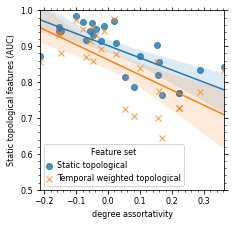

In [89]:
fontsize=8
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.30,3.3), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
  'lines.linewidth': 1,
#   'lines.markersize': 4,
  'legend.handlelength': .4,
  'font.family': 'sans-serif',
  'font.sans-serif': 'Helvetica',
  'savefig.transparent': True
}

with plt.rc_context(rc):
    ax = sns.regplot(data=df, x='Degree assortativity', y='Temporal topological features (AUC)', label='Static topological')
    ax = sns.regplot(data=df, x='Degree assortativity', y='Static topological features (AUC)', marker='x', ax=ax, label='Temporal weighted topological')
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.02))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.02))
    ax.set_ylim(.5, 1)
    ax.legend(title='Feature set')